# 7. 앙상블 학습과 랜덤 포레스트

**기본설정**

파이썬 3.7 이상을 요구한다.

In [1]:
import sys

assert sys.version_info >= (3, 7)

사이킷런 1.0.1 이상을 요구한다.

In [2]:
import sklearn

assert sklearn.__version__ >= "1.0.1"

다음은 이미지에 포함된 폰트 크기를 설정한다.

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## 7.1. 소개

## 7.2. 투표식 분류기

**직접 투표**

아래 코드는 초승달 데이터셋을 대상으로 3개의 분류기로 구성된 투표식 분류기를 훈련시킨다.

- 로직스틱 회귀
- 랜덤 포레스트 분류기
- SVC

In [4]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# 초승달 데이터셋
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
# 훈련셋/테스트셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 투표식 분류기
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)

# 훈련 시작
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

- 투표식 분류기 성능

In [5]:
voting_clf.score(X_test, y_test)

0.912

- 개별 학습기 성능: 앙상블 학습에 사용된 3 개의 분류기 각각의 성능은 보다 낮다.

In [6]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


- 직접 작동 확인: 첫째 샘플에 대한 예측값

In [7]:
voting_clf.predict(X_test[:1])

array([1], dtype=int64)

각 분류기의 예측값 중에 양성(1)을 예측값으로 사용하는 분류기가 다수다.

In [8]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64)]

**간접 투표**

간접투표가 가능하려면 다음 두 가지 설정을 확인한다.
 
- 투표식 분류기의 `voting='soft'` 하이퍼파라미터 지정
- `SVC`의 `probability=True` 하이퍼파라미터; `predict_proba()` 메서드 지원

In [9]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

간접 투표 방식이 직접 투표 방식보다 정확도가 보다 높다.

In [10]:
voting_clf.score(X_test, y_test)

0.92

## 7.3. 배깅과 페이스팅

### 7.3.1. 사이킷런의 배깅과 페이스팅

- 결정트리 500개로 구성된 배깅 분류기
- 각 결정트리의 훈련셋의 크기는 100. 중복 허용하면서 무작위로 선택됨.

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, random_state=42)

- `plot_decision_boundary()` 함수: 훈련된 분류기(`clf`)를 이용하여 양성/음성 결정 경계 그리기

In [12]:
import numpy as np

def plot_decision_boundary(clf, X, y, alpha=1.0):
    # x-축 범위: -1.5 ~ 2.4
    # y-축 범위: -1 ~ 1.5
    axes=[-1.5, 2.4, -1, 1.5]
    
    # 배경 화면과 양성/음성 결정 경계 그릭
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    
    # 양성/음성 데이터를 구분해서 산점도 그리기
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

아래 코드는 결정트리 모델 하나를 규제없이 사용할 때와,
규제 `max_samples=100`를 사용하는 결정트리 500개를 사용하는 배깅 분류기의 성능을 비교하는 그래프를 그린다.

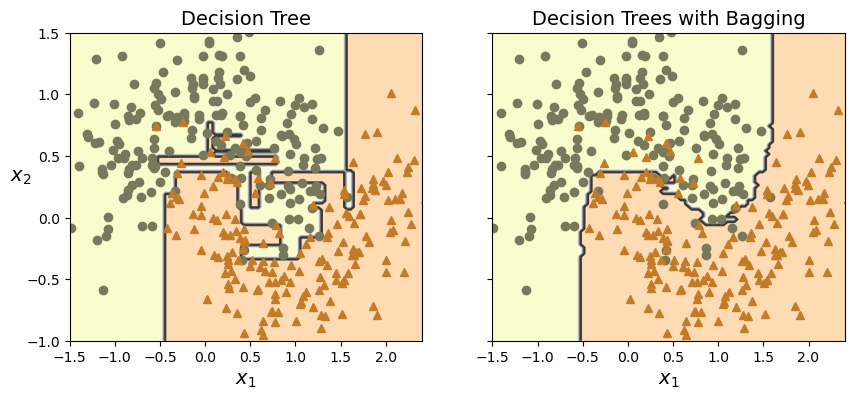

In [13]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# 왼쪽 그림
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")

# 오른쪽 그림
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
# save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

### 7.3.2. oob 평가

아래 코드는 배깅 모델 훈련이 끝난 후에 oob 평가를 진행한 결과를 보여준다.

In [14]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, random_state=42)
bag_clf.fit(X_train, y_train)

bag_clf.oob_score_

0.896

oob 평가 결과와 테스트 성능이 비슷하다.

In [15]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

각 훈련 샘플에 대한 oob 예측값은 `oob_decision_function_()` 메서드가 계산한다.
결정트리 모델이 `predict_proba()` 메서드를 지원하기에 양성, 음성 여부를 확률로 계산한다.

아래 코드는 처음 3개의 샘플에 대한 음성/양성 확률를 계산한다.

In [16]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

## 7.4. 랜덤 패치와 랜덤 서브스페이스

## 7.5. 랜덤 포레스트

랜덤 포레스트는 결정트리를 이용한 배깅 모델이다.
예를 들어 아래 랜덤 포레스트 모델과 그 아래 배깅 모델은 동일한 결과를 만들어 낸다.

- 랜덤 포레스트 분류기

In [17]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

- 배깅 분류기

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

실제로 두 모델의 예측값이 동일하다.

In [19]:
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

# 모든 테스트셋 샘플에 대한 예측값 동일
np.all(y_pred_bag == y_pred_rf)  

True

### 7.5.1. 엑스트라 트리

### 7.5.2 특성 중요도

**붓꽃 데이터셋 특성 중요도**

붓꽃의 경우 꽃잎의 길이와 너비가 가장 중요하다.

- `feature_importances_` 특성: 특성별 중요도 저장
- `iris.data.columns`: 특성 이름(꽃받침 길이/너비, 꽃잎 길이/너비)

In [20]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)

# 특성별 중요도 확인
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


**MNIST 데이터셋 특성 중요도**

MNIST 손글씨 데이터의 경우 기본적으로 숫자가 쓰여진 사진 중심부의 큰 부분이 
중요함을 아래 그림에서 확인할 수 있다.

- 특성 중요도 확인

In [21]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False, parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

# 특성별 중요도: 28*28 모양의 넘파이 어레이로 변환
heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)

- 특성별 중요도를 픽셀값으로 활용한 이미지 그리기
    - `cmap="hot"`: 색지도 지정

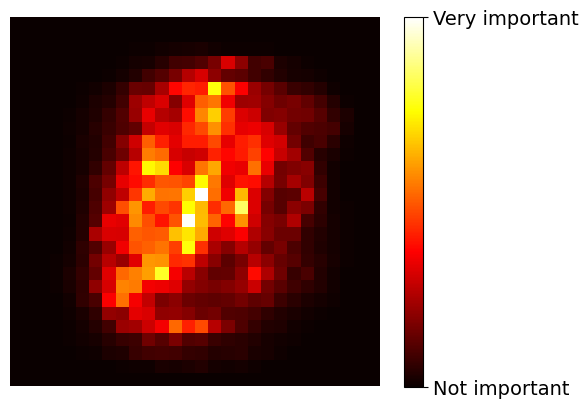

In [22]:
# 특성별 중요도를 픽셀값으로 활용.
plt.imshow(heatmap_image, cmap="hot")

# 색 막대
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])

# 색 막대 라벨 지정
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)

plt.axis("off")
plt.show()

## 7.6. 부스팅

## 7.6.1. 그레이디언트 부스팅

**작동 방식**

아래 코드는 3 개의 결정트리를 연속적으로 훈련시키는 그레이디언트 부스팅 기법이
진행되는 과정을 묘사한다.

- 2차 함수의 분포를 따르는 데이터셋 생성

In [23]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

- 한 개의 결정트리 회귀 모델 훈련

In [24]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

- 타깃을 잔차로 지정한 후에 동일한 훈련셋을 이용하여 다시 하나의 결정트리 회귀 모델 훈련

In [25]:
# 잔차
y2 = y - tree_reg1.predict(X)

tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

- 타깃을 "잔차의 잔차"로 지정한 후에 동일한 훈련셋을 이용하여 다시 하나의 결정트리 회귀 모델 훈련

In [26]:
# 잔차의 잔차
y3 = y2 - tree_reg2.predict(X)

tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

- 4개의 새로운 샘플에 대한 예측값 계산: 앞서 훈련된 3 개 모델의 예측값을 합한 값으로 계산됨

In [27]:
X_new = np.array([[-0.4], [-0.1], [0.2], [0.5]])

sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.17052257, 0.75026781])

위 과정을 요약하면 아래 그림과 같다.

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/handson-ml3/master/jupyter-book/imgs/ch07/homl07-11.png" width="700"/></div>

**사이킷런의 그레이디언트 부스팅 모델**

앞서 든 예제 코드를 아래 코드가 동일하게 수행한다.

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

앞서 사용된 4 개의 샘플에 대한 예측값이 이전과 동일한다.

In [29]:
gbrt.predict(X_new)

array([0.49484029, 0.04021166, 0.17052257, 0.75026781])

**조기 종료**

`n_iter_no_change=10` 하이퍼파라미터로 인해
원래 500 번 연속 결정트리를 훈련시켜야 하지만 실제로는 훨씬 일찍 훈련을 종료한다.

In [30]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

실제로 92번 훈련을 반복하였다. 

In [31]:
gbrt_best.n_estimators_

92

아래 코드는 다음 두 경우를 비교해서 보여준다.

- 왼쪽 그림
    - `learning_rate=1.0`
    - `n_estimators=3`
- 오른쪽 그림
    - `learning_rate=0.05`
    - `n_estimators=92`

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/handson-ml3/master/jupyter-book/imgs/ch07/homl07-12a.png" width="700"/></div>

### 7.6.2. XGBoost

붓꽃 데이터셋을 이용한 XGBoost 분류기 훈련을 살펴본다.

- 붓꽃 데이터셋 불러오기

In [32]:
from xgboost import XGBClassifier
from sklearn.datasets import load_iris

# 붓꽃 데이터셋
iris = load_iris(as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=.2)

- XGBoost 분류기 훈련
    - `n_estimators=2`: 2개의 결정트리 연속 훈련
    - `max_depth=2`: 결정트리 별로 최대 두 번 분할
    - `learning_rate=1`: 학습률
    - `objective='binary:logistic'`: 로지스틱 회귀의 비용함숫값이 최소가 되는 방향으로 결정트리의 마디(노드) 분할

In [33]:
xgb_clf = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=2, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

- 특성 중요도: 꽃받침의 길이와 너비는 전혀 중요하지 않다고 판단됨
    - `feature_importances_` 특성: 특성별 중요도 저장
    - `iris.data.columns`: 특성 이름(꽃받침 길이/너비, 꽃잎 길이/너비)

In [34]:
# 특성별 중요도 확인
for score, name in zip(xgb_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.01 sepal length (cm)
0.0 sepal width (cm)
0.85 petal length (cm)
0.14 petal width (cm)


## 연습문제

## 1. to 7.

1. If you have trained five different models and they all achieve 95% precision, you can try combining them into a voting ensemble, which will often give you even better results. It works better if the models are very different (e.g., an SVM classifier, a Decision Tree classifier, a Logistic Regression classifier, and so on). It is even better if they are trained on different training instances (that's the whole point of bagging and pasting ensembles), but if not this will still be effective as long as the models are very different.
2. A hard voting classifier just counts the votes of each classifier in the ensemble and picks the class that gets the most votes. A soft voting classifier computes the average estimated class probability for each class and picks the class with the highest probability. This gives high-confidence votes more weight and often performs better, but it works only if every classifier is able to estimate class probabilities (e.g., for the SVM classifiers in Scikit-Learn you must set `probability=True`).
3. It is quite possible to speed up training of a bagging ensemble by distributing it across multiple servers, since each predictor in the ensemble is independent of the others. The same goes for pasting ensembles and Random Forests, for the same reason. However, each predictor in a boosting ensemble is built based on the previous predictor, so training is necessarily sequential, and you will not gain anything by distributing training across multiple servers. Regarding stacking ensembles, all the predictors in a given layer are independent of each other, so they can be trained in parallel on multiple servers. However, the predictors in one layer can only be trained after the predictors in the previous layer have all been trained.
4. With out-of-bag evaluation, each predictor in a bagging ensemble is evaluated using instances that it was not trained on (they were held out). This makes it possible to have a fairly unbiased evaluation of the ensemble without the need for an additional validation set. Thus, you have more instances available for training, and your ensemble can perform slightly better.
5. When you are growing a tree in a Random Forest, only a random subset of the features is considered for splitting at each node. This is true as well for Extra-Trees, but they go one step further: rather than searching for the best possible thresholds, like regular Decision Trees do, they use random thresholds for each feature. This extra randomness acts like a form of regularization: if a Random Forest overfits the training data, Extra-Trees might perform better. Moreover, since Extra-Trees don't search for the best possible thresholds, they are much faster to train than Random Forests. However, they are neither faster nor slower than Random Forests when making predictions.
6. If your AdaBoost ensemble underfits the training data, you can try increasing the number of estimators or reducing the regularization hyperparameters of the base estimator. You may also try slightly increasing the learning rate.
7. If your Gradient Boosting ensemble overfits the training set, you should try decreasing the learning rate. You could also use early stopping to find the right number of predictors (you probably have too many).

## 8. Voting Classifier

Exercise: _Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing)._

The MNIST dataset was loaded earlier. The dataset is already split into a training set (the first 60,000 instances) and a test set (the last 10,000 instances), and the training set is already shuffled. So all we need to do is to take the first 50,000 instances for the new training set, the next 10,000 for the validation set, and the last 10,000 for the test set:

In [35]:
X_train, y_train = X_mnist[:50_000], y_mnist[:50_000]
X_valid, y_valid = X_mnist[50_000:60_000], y_mnist[50_000:60_000]
X_test, y_test = X_mnist[60_000:], y_mnist[60_000:]

Exercise: _Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM._

In [36]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [37]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [38]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [39]:
[estimator.score(X_valid, y_valid) for estimator in estimators]

[0.9736, 0.9743, 0.8662, 0.9648]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Exercise: _Next, try to combine \[the classifiers\] into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [40]:
from sklearn.ensemble import VotingClassifier

In [41]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [42]:
voting_clf = VotingClassifier(named_estimators)

In [43]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [44]:
voting_clf.score(X_valid, y_valid)

0.9752

The `VotingClassifier` made a clone of each classifier, and it trained the clones using class indices as the labels, not the original class names. Therefore, to evaluate these clones we need to provide class indices as well. To convert the classes to class indices, we can use a `LabelEncoder`:

In [45]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_valid_encoded = encoder.fit_transform(y_valid)

However, in the case of MNIST, it's simpler to just convert the class names to integers, since the digits match the class ids:

In [46]:
y_valid_encoded = y_valid.astype(np.int64)

Now let's evaluate the classifier clones:

In [47]:
[estimator.score(X_valid, y_valid_encoded)
 for estimator in voting_clf.estimators_]

[0.9736, 0.9743, 0.8662, 0.9648]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `"drop"` using `set_params()` like this:

In [48]:
voting_clf.set_params(svm_clf="drop")

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', 'drop'),
                             ('mlp_clf', MLPClassifier(random_state=42))])

This updated the list of estimators:

In [49]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', 'drop'),
 ('mlp_clf', MLPClassifier(random_state=42))]

However, it did not update the list of _trained_ estimators:

In [50]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

In [51]:
voting_clf.named_estimators_

{'random_forest_clf': RandomForestClassifier(random_state=42),
 'extra_trees_clf': ExtraTreesClassifier(random_state=42),
 'svm_clf': LinearSVC(max_iter=100, random_state=42, tol=20),
 'mlp_clf': MLPClassifier(random_state=42)}

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators, both in `estimators_` and `named_estimators_`:

In [52]:
svm_clf_trained = voting_clf.named_estimators_.pop("svm_clf")
voting_clf.estimators_.remove(svm_clf_trained)

Now let's evaluate the `VotingClassifier` again:

In [53]:
voting_clf.score(X_valid, y_valid)

0.9756

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [54]:
voting_clf.voting = "soft"

In [55]:
voting_clf.score(X_valid, y_valid)

0.9703

Nope, hard voting wins in this case.

_Once you have found \[an ensemble that performs better than the individual predictors\], try it on the test set. How much better does it perform compared to the individual classifiers?_

In [56]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9722

In [57]:
[estimator.score(X_test, y_test.astype(np.int64))
 for estimator in voting_clf.estimators_]

[0.968, 0.9703, 0.9644]

The voting classifier reduced the error rate of the best model from about 3% to 2.7%, which means 10% less errors.

## 9. Stacking Ensemble

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [58]:
X_valid_predictions = np.empty((len(X_valid), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_valid_predictions[:, index] = estimator.predict(X_valid)

In [59]:
X_valid_predictions

array([['3', '3', '3', '3'],
       ['8', '8', '8', '8'],
       ['6', '6', '6', '6'],
       ...,
       ['5', '5', '5', '5'],
       ['6', '6', '6', '6'],
       ['8', '8', '8', '8']], dtype=object)

In [60]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True,
                                            random_state=42)
rnd_forest_blender.fit(X_valid_predictions, y_valid)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [61]:
rnd_forest_blender.oob_score_

0.9728

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_

In [62]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [63]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [64]:
accuracy_score(y_test, y_pred)

0.9699

This stacking ensemble does not perform as well as the voting classifier we trained earlier, and it's even very slightly worse than the best individual classifier.

Exercise: _Now try again using a `StackingClassifier` instead: do you get better performance? If so, why?_

Since `StackingClassifier` uses K-Fold cross-validation, we don't need a separate validation set, so let's join the training set and the validation set into a bigger training set:

In [65]:
X_train_full, y_train_full = X_mnist[:60_000], y_mnist[:60_000]

Now let's create and train the stacking classifier on the full training set:

**Warning**: the following cell will take quite a while to run (15-30 minutes depending on your hardware), as it uses K-Fold validation with 5 folds by default. It will train the 4 classifiers 5 times each on 80% of the full training set to make the predictions, plus one last time each on the full training set, and lastly it will train the final model on the predictions. That's a total of 25 models to train!

In [66]:
from sklearn.ensemble import StackingClassifier

stack_clf = StackingClassifier(named_estimators,
                               final_estimator=rnd_forest_blender)
stack_clf.fit(X_train_full, y_train_full)

StackingClassifier(estimators=[('random_forest_clf',
                                RandomForestClassifier(random_state=42)),
                               ('extra_trees_clf',
                                ExtraTreesClassifier(random_state=42)),
                               ('svm_clf',
                                LinearSVC(max_iter=100, random_state=42,
                                          tol=20)),
                               ('mlp_clf', MLPClassifier(random_state=42))],
                   final_estimator=RandomForestClassifier(n_estimators=200,
                                                          oob_score=True,
                                                          random_state=42))

In [67]:
stack_clf.score(X_test, y_test)

0.9798

The `StackingClassifier` significantly outperforms the custom stacking implementation we tried earlier! This is for mainly two reasons:

* Since we could reclaim the validation set, the `StackingClassifier` was trained on a larger dataset.
* It used `predict_proba()` if available, or else `decision_function()` if available, or else `predict()`. This gave the blender much more nuanced inputs to work with.

And that's all for today, congratulations on finishing the chapter and the exercises!